In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import random
import numpy as np
import os
from PIL import Image
from matplotlib import pyplot as plt

In [82]:
train_dir = "../train/train"
test_dir = "../train/test"

class GameDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms=None):
    self.root = root
    self.transform = transforms

    self.im_path = os.listdir(self.root)

  def __len__(self):
    return len(self.im_path)

  def __getitem__(self, index):
    image_path = os.path.join(self.root, self.im_path[index])
    label = image_path.split('-')[2]

    # Load image
    img = Image.open(image_path)
    img = img.convert('RGB')

    if self.transform:
      img = self.transform(img)
    else:
      # Convert to tensor
      img = torch.from_numpy(np.array(img))
    
    rating_norm = float(label.split('.')[0]) / 100.0

    return (img, torch.tensor(rating_norm, dtype=torch.float32))

In [83]:
train_data = GameDataset(train_dir)
test_data = GameDataset(test_dir)

print(f"Train: {train_data}, len: {len(train_data)}")
print(f"Image shape: {train_data[0][0].shape}")

Train: <__main__.GameDataset object at 0x2899ad760>, len: 1898
Image shape: torch.Size([337, 600, 3])


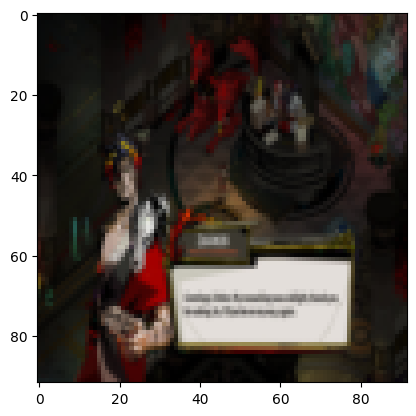

In [84]:
from torch.utils.data import DataLoader

train_transforms = transforms.Compose(
  [
    transforms.Resize(size=(92, 92)),
    transforms.ToTensor(),
  ]
)

test_transforms = transforms.Compose(
  [
    transforms.Resize(size=(92, 92)),
    transforms.ToTensor(),
  ]
)

train_data_custom = GameDataset(
  root=train_dir,
  transforms=train_transforms,
)

test_data_custom = GameDataset(
  root=test_dir,
  transforms=test_transforms,
)

# TESTING: show a random image
img, target = test_data_custom[0]
img_permute = img.permute(1, 2, 0)

plt.imshow(img_permute)
plt.show()

In [85]:
train_dataloader = torch.utils.data.DataLoader(train_data_custom, batch_size=32, shuffle=True, num_workers=0)
test_dataloader = torch.utils.data.DataLoader(test_data_custom, batch_size=32, shuffle=False, num_workers=0)

In [86]:
from torchvision import models

class ReviewPredictionModel(nn.Module):
    def __init__(self):
        super(ReviewPredictionModel, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 1)  # Output a single value
    
    def forward(self, x):
        return self.model(x)

In [87]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

model = ReviewPredictionModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for images, ratings in train_dataloader:
        images, ratings = images.to(device), ratings.to(device)
        
        optimizer.zero_grad()
        outputs = model(images).squeeze()  # Remove unnecessary dimensions
        loss = criterion(outputs, ratings)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss / len(train_dataloader)}")

    # Validation step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, ratings in test_dataloader:
            images, ratings = images.to(device), ratings.to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, ratings)
            val_loss += loss.item()
    
    print(f"Validation Loss: {val_loss / len(test_dataloader)}")

# Save the model
torch.save(model.state_dict(), 'model.pt')

Epoch 1/20, Train Loss: 0.24946687159438927
Validation Loss: 0.16392146128004995
Epoch 2/20, Train Loss: 0.18754178285598755
Validation Loss: 0.09854084368923614
Epoch 3/20, Train Loss: 0.09787134422610204
Validation Loss: 0.06264739098220036
Epoch 4/20, Train Loss: 0.06099354705462853
Validation Loss: 0.06123212750615745
Epoch 5/20, Train Loss: 0.039782384503632785
Validation Loss: 0.04354398671923013
Epoch 6/20, Train Loss: 0.027267185489957532
Validation Loss: 0.035362463572929645
Epoch 7/20, Train Loss: 0.018361210776492953
Validation Loss: 0.034161705074125324
Epoch 8/20, Train Loss: 0.015024983479330936
Validation Loss: 0.03330137985276765
Epoch 9/20, Train Loss: 0.012354268529452383
Validation Loss: 0.028221243029010707
Epoch 10/20, Train Loss: 0.009355229632152866
Validation Loss: 0.027454700802677666
Epoch 11/20, Train Loss: 0.007734908179069559
Validation Loss: 0.024276428791726458
Epoch 12/20, Train Loss: 0.0067460939365749555
Validation Loss: 0.02412217184258946
Epoch 13/20

In [90]:

# Path to your test image
test_image_path = "../train/test/238320-0-96.jpg"

# Transform for the test image (same as training)
transform = train_transforms

# Load the trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model = ReviewPredictionModel()  # Replace with your model class
model.load_state_dict(torch.load("model.pt", map_location=device))
model.to(device)
model.eval()

# Load and preprocess the test image
image = Image.open(test_image_path).convert('RGB')
image = transform(image).unsqueeze(0)  # Add batch dimension

# Perform inference
with torch.no_grad():
    image = image.to(device)
    predicted_rating = model(image).item()  # Get the predicted rating as a scalar

# Convert the normalized rating back to percentage
predicted_percentage = predicted_rating * 100
print(f"Predicted Rating: {predicted_percentage:.2f}%")


/var/folders/jm/bynsxh5s3hd1z2qs_r0r9w2m0000gn/T/ipykernel_51209/3971369245.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pt",

Predicted Rating: 76.73%
